- Tutorial from [here](https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7)
- Code [here](https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch)
- original paper :[here](https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf)
- Siamese nets were first introduced in the early 1990s by Bromley and LeCun to solve signature verification

additional detail the paper use
- use Regularization
- Early stop if no derease error for 20 epochs
- layerwise learning rate ηj ∈ [10−4
, 10−1
], layer-wise momentum µj ∈ [0, 1], and layer-wise L2 regularization penalty
λj ∈ [0, 0.1]
- Affine distortions (augmented data)

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            nn.Dropout2d(p=.2),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
            nn.Dropout2d(p=.2),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5)
        )

    def forward_once(self, x):
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [4]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))
        return loss_contrastive


In [ ]:
class Config():
    training_dir = "./data/faces/training/"
    testing_dir = "./data/faces/testing/"
    train_batch_size = 64
    train_number_epochs = 10

In [6]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, root):
        self.class_dict = {}
        self.image_folder = datasets.ImageFolder(root)
        transform = transforms.Compose([
                        transforms.Resize((100,100)),
                        transforms.ToTensor()
                    ])
        self.all_images = []
        
        # 1. separate paths by index, open image, and transform
        for path, class_index in self.image_folder.imgs:
            if class_index not in self.class_dict:
                self.class_dict[class_index] = []
            image = transform(
                        Image.open(path).convert('L') # L is grayscale mode
                    )
            self.class_dict[class_index].append(image)
            self.all_images.append((image, class_index))
            
        # 2. prepare dict of other indexes that are not current index (for random)
        indexes = [self.image_folder.class_to_idx[class_name]
                   for class_name in self.image_folder.classes]
        self.not_index = {}
        for index in indexes:
            new_indexes = indexes[:]
            new_indexes.remove(index)
            self.not_index[index] = new_indexes
        
    def get_images_by_class_index(self, class_index):
        return self.class_dict[class_index]
    
    def __getitem__(self, index):
        image_0, class_index_0 = random.choice(self.all_images)
        is_same_class = random.randint(0, 1)
        if is_same_class:
            class_index_1 = class_index_0
        else:
            # to make sure getting images from same class 50%
            class_index_1 = random.choice(self.not_index[class_index_0])
        image_1 = random.choice(self.get_images_by_class_index(class_index_1))
        
        return image_0, image_1, torch.tensor(is_same_class, dtype=torch.float32)
    def __len__(self):
        return len(self.image_folder.imgs)

In [7]:
siamese_dataset = SiameseNetworkDataset(root=Config.testing_dir)
data_loader = DataLoader(siamese_dataset, shuffle=True, num_workers=8, batch_size=8)
example_batch = next(iter(data_loader))

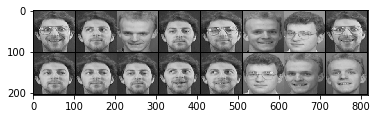

tensor([1., 1., 0., 1., 1., 0., 0., 0.])


In [8]:
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
img = torchvision.utils.make_grid(concatenated)
img = img.numpy()

plt.imshow(np.transpose(img, (1, 2, 0)))
plt.show()
print(example_batch[2])

### Train

In [15]:
train_dataset = SiameseNetworkDataset(root=Config.training_dir)
train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=8, batch_size=Config.train_batch_size)

In [16]:
net = SiameseNetwork().to(device)
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [19]:
counter = []
loss_history = [] 
for epoch in range(0, Config.train_number_epochs):
    for i, (image_1, image_2, is_same) in enumerate(train_dataloader):
        optimizer.zero_grad()
        y1, y2 = net(image_1, image_2)
        loss_contrastive = criterion(y1, y2, is_same)
        loss_contrastive.backward()
        optimizer.step()
    print(f'Epoch {epoch}, loss: {loss_contrastive.item()}')
    counter.append(epoch)
    loss_history.append(loss_contrastive.item())

Epoch 0, loss: 1.2644226551055908
Epoch 1, loss: 1.404215931892395
Epoch 2, loss: 1.2449984550476074
Epoch 3, loss: 1.2418289184570312
Epoch 4, loss: 1.0406948328018188
Epoch 5, loss: 1.1487791538238525
Epoch 6, loss: 1.1991032361984253
Epoch 7, loss: 1.0243315696716309
Epoch 8, loss: 1.3574482202529907
Epoch 9, loss: 1.0210750102996826
Epoch 10, loss: 1.2822951078414917
Epoch 11, loss: 0.9759364724159241
Epoch 12, loss: 0.9916995167732239
Epoch 13, loss: 1.116220235824585
Epoch 14, loss: 1.1147408485412598
Epoch 15, loss: 1.1226756572723389
Epoch 16, loss: 1.224867343902588
Epoch 17, loss: 1.2366302013397217
Epoch 18, loss: 1.2283121347427368
Epoch 19, loss: 1.065193772315979
Epoch 20, loss: 1.3408757448196411
Epoch 21, loss: 1.4173223972320557
Epoch 22, loss: 1.0723825693130493
Epoch 23, loss: 1.1434158086776733
Epoch 24, loss: 1.1155790090560913
Epoch 25, loss: 1.4207202196121216
Epoch 26, loss: 1.1182856559753418
Epoch 27, loss: 1.1845260858535767
Epoch 28, loss: 1.3025212287902832

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/Users/epinyoanun/miniconda3/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/Users/epinyoanun/miniconda3/lib/

KeyboardInterrupt: 